<a href="https://colab.research.google.com/github/mmaruthi/S5-Assignment-Solution/blob/master/step16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-9.0, 9.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

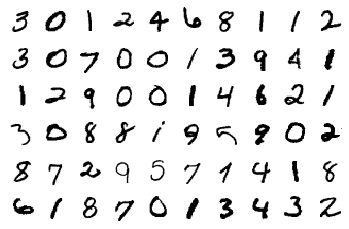

In [16]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(0.2),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(0.2),
            nn.ReLU()
        ) # output_size = 24

                # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(0.2),
            nn.ReLU()
        ) # output_size = 10

        # TRANSITION BLOCK 1
        #self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        #self.convblock4 = nn.Sequential(
         #   nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            
            
        #    nn.ReLU()
        #) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(0.2),
            nn.ReLU()
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 6

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(0.2),
            nn.ReLU()
        ) # output_size = 6
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(6, 6), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        #x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        #x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        #x = self.convblock7(x)
        #x = self.convblock8(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [18]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
           Dropout-3           [-1, 10, 26, 26]               0
              ReLU-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
       BatchNorm2d-6           [-1, 10, 24, 24]              20
           Dropout-7           [-1, 10, 24, 24]               0
              ReLU-8           [-1, 10, 24, 24]               0
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 20, 10, 10]           1,800
      BatchNorm2d-11           [-1, 20, 10, 10]              40
          Dropout-12           [-1, 20, 10, 10]               0
             ReLU-13           [-1, 20, 10, 10]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [20]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.33818182349205017 Batch_id=468 Accuracy=81.08: 100%|██████████| 469/469 [00:11<00:00, 41.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3467, Accuracy: 9282/10000 (92.82%)

EPOCH: 1


Loss=0.14845290780067444 Batch_id=468 Accuracy=95.08: 100%|██████████| 469/469 [00:11<00:00, 42.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2185, Accuracy: 9466/10000 (94.66%)

EPOCH: 2


Loss=0.2124681919813156 Batch_id=468 Accuracy=96.23: 100%|██████████| 469/469 [00:11<00:00, 42.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2089, Accuracy: 9475/10000 (94.75%)

EPOCH: 3


Loss=0.07531656324863434 Batch_id=468 Accuracy=96.78: 100%|██████████| 469/469 [00:11<00:00, 41.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1274, Accuracy: 9694/10000 (96.94%)

EPOCH: 4


Loss=0.11701486259698868 Batch_id=468 Accuracy=97.15: 100%|██████████| 469/469 [00:11<00:00, 41.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1327, Accuracy: 9676/10000 (96.76%)

EPOCH: 5


Loss=0.11555495113134384 Batch_id=468 Accuracy=97.34: 100%|██████████| 469/469 [00:11<00:00, 41.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1114, Accuracy: 9713/10000 (97.13%)

EPOCH: 6


Loss=0.1064448356628418 Batch_id=468 Accuracy=97.42: 100%|██████████| 469/469 [00:10<00:00, 42.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0908, Accuracy: 9766/10000 (97.66%)

EPOCH: 7


Loss=0.06632102280855179 Batch_id=468 Accuracy=97.50: 100%|██████████| 469/469 [00:11<00:00, 41.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0766, Accuracy: 9792/10000 (97.92%)

EPOCH: 8


Loss=0.11289628595113754 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:10<00:00, 42.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0867, Accuracy: 9771/10000 (97.71%)

EPOCH: 9


Loss=0.07772292196750641 Batch_id=468 Accuracy=97.71: 100%|██████████| 469/469 [00:10<00:00, 42.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0692, Accuracy: 9814/10000 (98.14%)

EPOCH: 10


Loss=0.10223527997732162 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:11<00:00, 42.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0591, Accuracy: 9850/10000 (98.50%)

EPOCH: 11


Loss=0.08690673112869263 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:11<00:00, 41.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0630, Accuracy: 9830/10000 (98.30%)

EPOCH: 12


Loss=0.0754329115152359 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:11<00:00, 41.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0668, Accuracy: 9825/10000 (98.25%)

EPOCH: 13


Loss=0.053688108921051025 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:11<00:00, 41.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0593, Accuracy: 9846/10000 (98.46%)

EPOCH: 14


Loss=0.04643348231911659 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:11<00:00, 42.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0607, Accuracy: 9828/10000 (98.28%)

EPOCH: 15


Loss=0.021303797140717506 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:11<00:00, 41.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0594, Accuracy: 9826/10000 (98.26%)

EPOCH: 16


Loss=0.12053439021110535 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:11<00:00, 41.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0560, Accuracy: 9857/10000 (98.57%)

EPOCH: 17


Loss=0.0502842552959919 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:11<00:00, 41.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0605, Accuracy: 9828/10000 (98.28%)

EPOCH: 18


Loss=0.11580586433410645 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:11<00:00, 41.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0493, Accuracy: 9872/10000 (98.72%)

EPOCH: 19


Loss=0.09227899461984634 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:11<00:00, 42.60it/s]



Test set: Average loss: 0.0503, Accuracy: 9863/10000 (98.63%)



Text(0.5, 1.0, 'Test Accuracy')

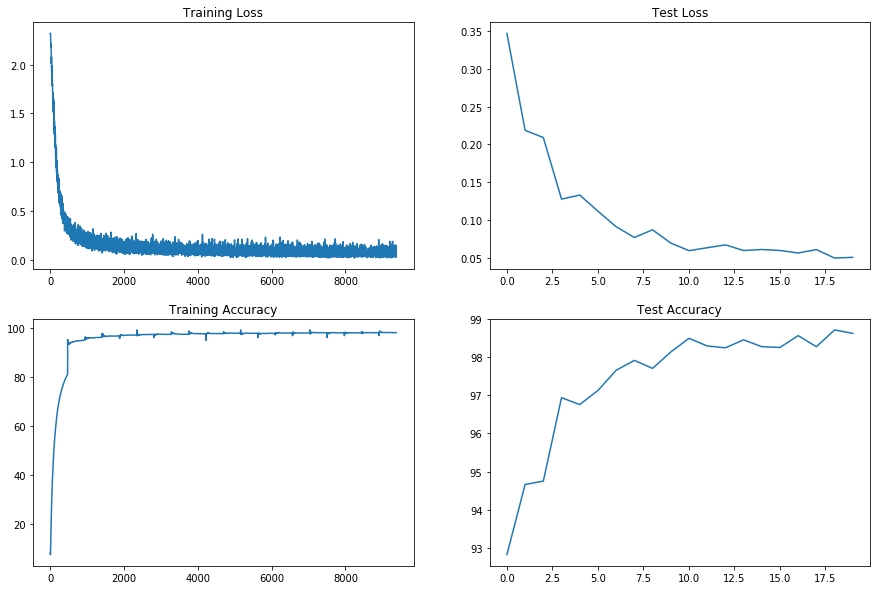

In [21]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")